In [4]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras
import tensorflow_probability as tfp


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [10]:
train_size = 60000
batch_size = 100
test_size = 10000
input_shape = (28, 28, 1)

# MNIST dataset

In [9]:
mnist = tfk.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

11493376/11490434 [==============================] - 0s 0us/step


In [13]:
x_test.shape

(10000, 28, 28)

In [11]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

# Variational Autoencoder

In [12]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [82]:
def Encoder(latent_dim):

    inputs = tfkl.Input(shape=[28, 28])
    z = tfkl.Flatten()(inputs)
    z = tfkl.Dense(300, activation="relu", kernel_initializer="he_normal")(z)
    z = tfkl.Dense(300, activation="relu")(z)
    codings_mean = tfkl.Dense(latent_dim)(z)
    codings_log_var = tfkl.Dense(latent_dim)(z)
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tfk.models.Model(inputs=[inputs], outputs=[codings])

    return codings_mean, codings_log_var, variational_encoder

def Decoder(latent_dim):

    decoder_inputs = keras.layers.Input(shape=[latent_dim])
    x = keras.layers.Dense(300, activation="relu")(decoder_inputs)
    x = keras.layers.Dense(300, activation="relu")(x)
    x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
    outputs = keras.layers.Reshape([28, 28])(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

    return variational_decoder

class VAE(tfk.Model):
    def __init__(
        self,
        encoder,
        decoder,
        kl_weight, 
        lr
    ):
        super(VAe, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.lr = lr 

    def compile(
        self,
        optimizer,
        loss_elbo_fn
    ):
        super(VAE, self).compile()
        self.loss_elbo_fn = loss_elbo_fn 
        self.optimizer = optimizer

    def train_step(self, x):
        with tf.GradientTape(persistent=True) as tape:
            mean , logvar, inferred = self.encoder(x)
            reconstructed = self.decoder(inferred)

            kl_divergence = -0.5 * K.sum(1 + logvar - K.exp(logvar) - K.square(mean), axis=-1)
            kl_divergence = kl_weight * K.mean(kl_divergence) / 784.

            


In [79]:
latent_dim = 40
kl_weight = 3
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal")(z)
z = keras.layers.Dense(300, activation="relu")(z)
codings_mean = keras.layers.Dense(latent_dim)(z)
codings_log_var = keras.layers.Dense(latent_dim)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings])

decoder_inputs = keras.layers.Input(shape=[latent_dim])
x = keras.layers.Dense(300, activation="relu")(decoder_inputs)
x = keras.layers.Dense(300, activation="relu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
model = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

kl_divergence = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
model.add_loss(kl_weight * K.mean(kl_divergence) / 784.)

In [81]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
with tf.device('/device:GPU:0'):
    history = model.fit(x_train, x_train, epochs=100, batch_size=100)

Epoch 1/100
600/600 [==============================] - 3s 3ms/step - loss: 0.1806 - accuracy: 0.2145
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1784 - accuracy: 0.2166
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1767 - accuracy: 0.2209
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1757 - accuracy: 0.2226
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1747 - accuracy: 0.2257
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1742 - accuracy: 0.2272
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1732 - accuracy: 0.2299
Epoch 8/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1729 - accuracy: 0.2304
Epoch 9/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1722 - accuracy: 0.2325
Epoch 10/100
600/600 [==============================] - 2s 3ms/step - loss: 0.1718 - accura

In [83]:
model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_39 (Functional)           (None, 40)           349880      input_28[0][0]                   
__________________________________________________________________________________________________
model_40 (Functional)           (None, 28, 28)       338584      model_39[0][0]                   
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 784)          0           input_28[0][0]                   
___________________________________________________________________________________________

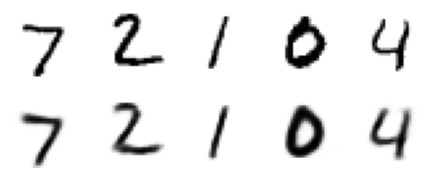

In [84]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=x_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(model)

In [ ]:
print("test-colab-2")

test-colab
